In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Load the dataset
# Assuming the CSV file 'rels_sample2.csv' is in the same directory or path is specified
try:
    df = pd.read_csv('rels.csv', low_memory=False)
except FileNotFoundError:
    print("Error: Dataset file not found. Please ensure 'rels_sample.csv' is in the correct path.")
    exit()

# Display basic information about the dataframe
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nColumns in the dataset:")
print(df.columns)
print("\nData types of columns:")
print(df.dtypes)

# --- Data Cleaning and Preprocessing ---

# Convert date columns to datetime objects, handling potential errors
def parse_date(date_str):
    if pd.isna(date_str):
        return None
    # Add more formats if necessary based on data inspection
    formats_to_try = ['%d-%b-%y', '%d-%b-%Y', '%Y-%m-%d', '%m/%d/%Y']
    for fmt in formats_to_try:
        try:
            return datetime.strptime(str(date_str), fmt)
        except (ValueError, TypeError):
            continue
    # print(f"Warning: Could not parse date {date_str}") # Optional: for debugging
    return None

date_columns = ['incorporation_date_start', 'inactivation_date_start', 'struck_off_date_start',
                'incorporation_date_end', 'inactivation_date_end', 'struck_off_date_end', 'dorm_date_end']
for col in date_columns:
    if col in df.columns:
        df[col] = df[col].apply(parse_date)

# Handle missing values for key analytical columns
# For categorical columns used in grouping, fill NaN with a placeholder like 'Unknown' or 'Not Specified'

# Define the list of categorical columns you want to process.
# Adjust this list based on the actual columns in your DataFrame.
categorical_cols_to_fill = [
    'jurisdiction_description_start', 'jurisdiction_description_end',
    'type_start', 'type_end',
    'status_start', 'status_end',
    'company_type_start', 'company_type_end',
    'countries_start', 'country_codes_start',
    'countries_end', 'country_codes_end',
    'link_type', 'link_status', # Assuming these might exist and are categorical
    'source_id_start', 'source_id_end' # Assuming these might exist and are categorical
]
for col in categorical_cols_to_fill:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Standardize text (e.g., lowercase, strip whitespace) for consistency in categorical fields
for col in categorical_cols_to_fill: # Iterate over the same list or a relevant subset
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower()
        # Replace empty strings that might result from stripping with 'Unknown' or a specific placeholder
        df[col] = df[col].replace('', 'Unknown')


# Function to parse semicolon-separated country fields
def parse_semicolon_separated_string(value):
    if pd.isna(value) or value.lower() == 'unknown' or value == '':
        return
    return [c.strip().lower() for c in str(value).split(';') if c.strip()]

if 'countries_start' in df.columns:
    df['countries_start_list'] = df['countries_start'].apply(parse_semicolon_separated_string)
if 'country_codes_start' in df.columns:
    df['country_codes_start_list'] = df['country_codes_start'].apply(parse_semicolon_separated_string)
if 'countries_end' in df.columns:
    df['countries_end_list'] = df['countries_end'].apply(parse_semicolon_separated_string)
if 'country_codes_end' in df.columns:
    df['country_codes_end_list'] = df['country_codes_end'].apply(parse_semicolon_separated_string)

print("\nPreprocessing complete. Sample of processed data:")
print(df[['node_id_start', 'incorporation_date_end', 'jurisdiction_description_end', 'countries_start_list']].head())

Dataset Shape: (500000, 42)

First 5 rows of the dataset:
   node_id_start  node_id_end            rel_type  \
0       23000436     20111548     intermediary_of   
1       23000246     20050981     intermediary_of   
2       56008636     58080065  registered_address   
3      110020422    110088539        same_name_as   
4       12171472     12180735             similar   

                          link                                    sourceID  \
0              intermediary of                               Bahamas Leaks   
1              intermediary of                               Bahamas Leaks   
2           registered address  Paradise Papers - Malta corporate registry   
3                 same name as                                         NaN   
4  similar name and address as                                         NaN   

  address_start                name_start countries_start country_codes_start  \
0           NaN  UNIVERSAL LEGAL SERVICES         Bahamas                


--- Jurisdictional and Entity Type Analysis ---

Top 20 Incorporation Jurisdictions (End Node is Entity):
jurisdiction_description_end
malta                     84812
british virgin islands    81689
bahamas                   41712
bermuda                   25772
barbados                  22174
undetermined              17200
panama                    17027
saint kitts and nevis     10576
aruba                     10180
samoa                     10013
cayman islands             7248
seychelles                 6897
cook islands               3397
unknown                    2326
niue                       1984
isle of man                1703
jersey                     1593
british anguilla           1089
cayman                     1047
mauritius                   684
Name: count, dtype: int64

Top 20 Entity Types (End Node is Entity):
company_type_end
unknown                                           286331
standard international company                     32573
business company limited

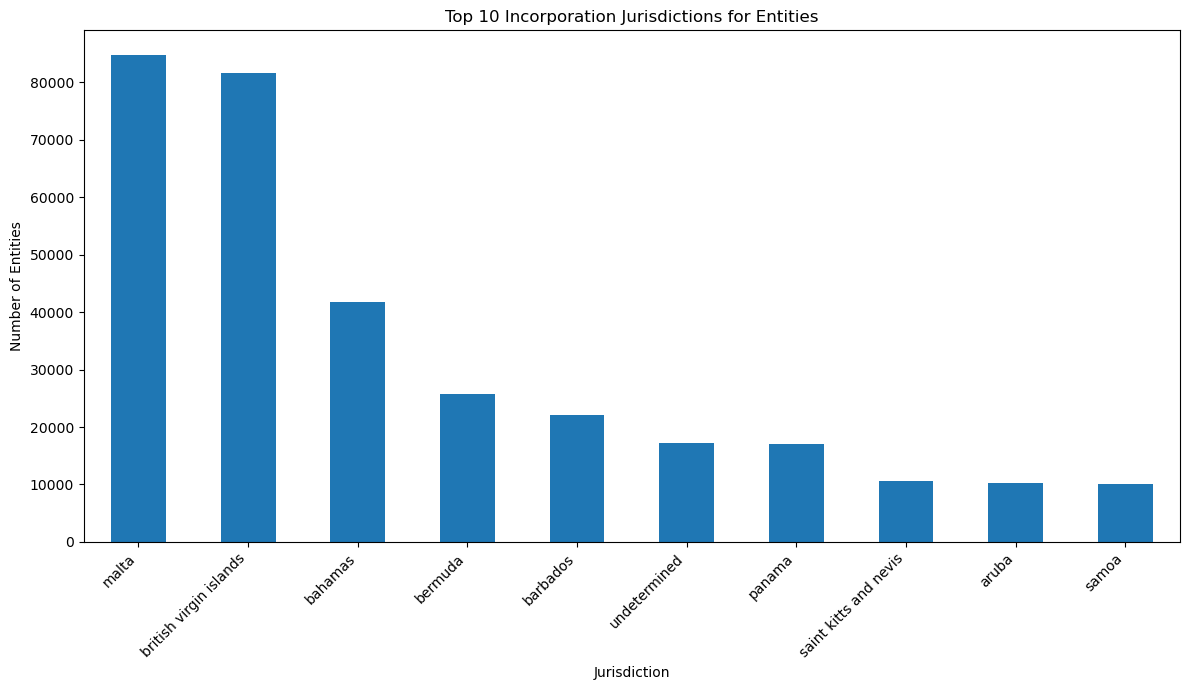

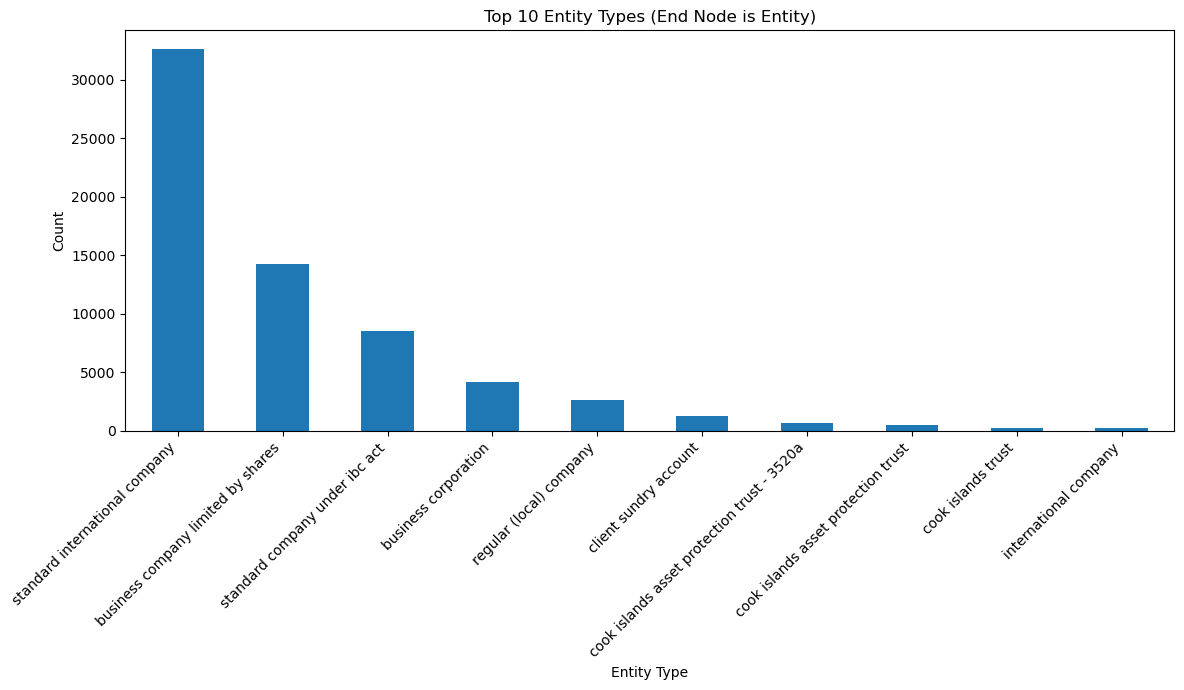

In [12]:
# --- Jurisdictional and Entity Type Analysis ---
print("\n--- Jurisdictional and Entity Type Analysis ---")

# Filter for records where the end node is an entity
df_entities_end = df[df['node_type_end'] == 'entity'].copy() # Use.copy() to avoid SettingWithCopyWarning

# Frequency of incorporation jurisdictions (jurisdiction_description_end)
jurisdiction_counts_end = df_entities_end['jurisdiction_description_end'].value_counts()
print("\nTop 20 Incorporation Jurisdictions (End Node is Entity):")
print(jurisdiction_counts_end.head(20))

# Frequency of entity types (company_type_end) for entities
entity_type_counts_end = df_entities_end['company_type_end'].value_counts()
print("\nTop 20 Entity Types (End Node is Entity):")
print(entity_type_counts_end.head(20))

# Table: Frequency of Top 5 Entity Types by Top 5 Offshore Jurisdictions
# Identify top 5 jurisdictions (excluding 'unknown' or overly broad categories if necessary)
top_jurisdictions = jurisdiction_counts_end[jurisdiction_counts_end.index!= 'unknown'].head(5).index.tolist()

# Filter the entity dataframe for these top jurisdictions
df_top_jur_entities = df_entities_end[df_entities_end['jurisdiction_description_end'].isin(top_jurisdictions)]

# Group by jurisdiction and company type, then count
entity_type_by_jurisdiction = df_top_jur_entities.groupby(['jurisdiction_description_end', 'company_type_end']).size().reset_index(name='count')
# Sort by jurisdiction ascending, then by count descending to get top entity types first for each jurisdiction
entity_type_by_jurisdiction = entity_type_by_jurisdiction.sort_values(by=['jurisdiction_description_end', 'count'], ascending=[True, False])

print("\nFrequency of Entity Types by Top Offshore Jurisdictions:")
# To get top 5 entity types *within each* of these top jurisdictions:
top_entity_types_by_jurisdiction_table = entity_type_by_jurisdiction.groupby('jurisdiction_description_end').head(5)
print(top_entity_types_by_jurisdiction_table)

# Plotting example for top jurisdictions
plt.figure(figsize=(12, 7))
jurisdiction_counts_end[jurisdiction_counts_end.index!= 'unknown'].head(10).plot(kind='bar')
plt.title('Top 10 Incorporation Jurisdictions for Entities')
plt.xlabel('Jurisdiction')
plt.ylabel('Number of Entities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# plt.savefig('top_incorporation_jurisdictions.png')
# plt.show()
print("\nPlot for top incorporation jurisdictions generated (commented out).")

# Plotting example for top entity types
plt.figure(figsize=(12, 7))
entity_type_counts_end[entity_type_counts_end.index!= 'unknown'].head(10).plot(kind='bar')
plt.title('Top 10 Entity Types (End Node is Entity)')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# plt.savefig('top_entity_types.png')
# plt.show()
print("Plot for top entity types generated (commented out).")

In [13]:
# --- "Stepping Stone" Analysis ---
print("\n--- Stepping Stone Analysis ---")

# Filter for records where end node is an entity and has a valid incorporation jurisdiction
df_stepping_stone_analysis = df_entities_end[
    (df_entities_end['jurisdiction_description_end']!= 'unknown') &
    (df_entities_end['jurisdiction_description_end']!= '')
].copy()

# Explode the 'countries_start_list' to have one row per origin country
df_exploded_origins = df_stepping_stone_analysis.explode('countries_start_list')
df_exploded_origins = df_exploded_origins.rename(columns={'countries_start_list': 'origin_country'})

# Filter out records where origin_country is missing, unknown, or same as incorporation jurisdiction
df_stepping_stones = df_exploded_origins[
    df_exploded_origins['origin_country'].notna() &
    (df_exploded_origins['origin_country']!= 'unknown') &
    (df_exploded_origins['origin_country']!= '') &
    (df_exploded_origins['origin_country']!= df_exploded_origins['jurisdiction_description_end'])
]

# Calculate frequency of (Origin Country -> Incorporation Jurisdiction) dyads
stepping_stone_dyads = df_stepping_stones.groupby(['origin_country', 'jurisdiction_description_end']).size().reset_index(name='count')
stepping_stone_dyads = stepping_stone_dyads.sort_values(by='count', ascending=False)

print("\nTop 20 'Stepping Stone' Dyads (Origin Country -> Incorporation Jurisdiction):")
print(stepping_stone_dyads.head(20))

# Data for Sankey/Chord diagram (conceptual)
# For a Sankey, you'd typically group origins and destinations if there are too many unique values.
# Example: Top N origins, Top M destinations, and an 'Other' category.
# sankey_data = stepping_stone_dyads.rename(columns={'origin_country': 'source', 'jurisdiction_description_end': 'target', 'count': 'value'})
# print("\nSample data structure for Sankey/Chord diagram:")
# print(sankey_data.head())


--- Stepping Stone Analysis ---

Top 20 'Stepping Stone' Dyads (Origin Country -> Incorporation Jurisdiction):
      origin_country jurisdiction_description_end  count
792        hong kong       british virgin islands  14500
1681       singapore       british virgin islands   9470
2041   united states                      bermuda   8562
2000  united kingdom                      bermuda   7813
851        indonesia       british virgin islands   7409
399            china       british virgin islands   6339
1884        thailand       british virgin islands   6277
2002  united kingdom       british virgin islands   4994
2015  united kingdom                        malta   4888
1401  not identified       british virgin islands   4805
956            italy                        malta   4271
1416  not identified                 undetermined   4149
994           jersey       british virgin islands   3851
1852          taiwan       british virgin islands   3657
1817     switzerland       britis

In [20]:
# --- Sankey/Chord Diagram Data Preparation ---
print("\n--- Sankey/Chord Diagram Data Preparation ---")

# Rename columns for Sankey diagram compatibility
# The 'stepping_stone_dyads' DataFrame is already sorted by 'count' in descending order
sankey_data = stepping_stone_dyads.rename(columns={
    'origin_country': 'source',
    'jurisdiction_description_end': 'target',
    'count': 'value'
})

print("\nSample data structure for Sankey/Chord diagram (Top 20 dyads):")
print(sankey_data.head(20))

# Conceptual: Grouping for Sankey if too many unique values
# This part remains conceptual as the optimal N and M depend on visualization goals and data distribution.
# For a practical Sankey, you might select top N sources, top M targets,
# and aggregate the rest into 'Other_Source' or 'Other_Target'.

# Example: Define Top N sources and Top M targets
N_top_sources = 10
M_top_targets = 10

# Get the actual top N sources and M targets from the sankey_data
top_sources_list = sankey_data.groupby('source')['value'].sum().nlargest(N_top_sources).index.tolist()
top_targets_list = sankey_data.groupby('target')['value'].sum().nlargest(M_top_targets).index.tolist()

# Create a copy for modification
sankey_data_grouped = sankey_data.copy()

# Group sources not in top N into 'Other_Source'
sankey_data_grouped['source'] = sankey_data_grouped['source'].apply(
    lambda x: x if x in top_sources_list else 'Other_Source'
)
# Group targets not in top M into 'Other_Target'
sankey_data_grouped['target'] = sankey_data_grouped['target'].apply(
    lambda x: x if x in top_targets_list else 'Other_Target'
)

# Aggregate counts after grouping
sankey_data_aggregated = sankey_data_grouped.groupby(['source', 'target'])['value'].sum().reset_index()
sankey_data_aggregated = sankey_data_aggregated.sort_values(by='value', ascending=False)

print(f"\nSample data structure for Sankey after grouping (Top {N_top_sources} sources, Top {M_top_targets} targets, rest as 'Other'):")
print(sankey_data_aggregated.head(20))

# Further filtering: remove self-loops if 'Other_Source' maps to 'Other_Target' and it's not meaningful
sankey_data_aggregated = sankey_data_aggregated[~((sankey_data_aggregated['source'] == 'Other_Source') & (sankey_data_aggregated['target'] == 'Other_Target'))]


# Note: To actually plot a Sankey diagram, you would typically use a library like `plotly`.
# Example using plotly (requires plotly to be installed: pip install plotly)
import plotly.graph_objects as go

if not sankey_data_aggregated.empty:
    # Create lists of unique nodes (sources and targets)
    all_nodes = pd.concat([sankey_data_aggregated['source'], sankey_data_aggregated['target']]).unique()
    node_map = {name: i for i, name in enumerate(all_nodes)}

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_nodes,
            # color="blue" # You can customize node colors
        ),
        link=dict(
            source=[node_map[s] for s in sankey_data_aggregated['source']],
            target=[node_map[t] for t in sankey_data_aggregated['target']],
            value=sankey_data_aggregated['value']
        ))])

    fig.update_layout(title_text=f"Stepping Stone Flows (Top {N_top_sources} Origins to Top {M_top_targets} Jurisdictions)",
                      font_size=10)
    fig.show() # Uncomment to display the figure
    print("\nSankey diagram can be generated using Plotly (call fig.show() to display).")
else:
    print("\nNot enough data to generate a meaningful Sankey diagram after grouping.")





--- Sankey/Chord Diagram Data Preparation ---

Sample data structure for Sankey/Chord diagram (Top 20 dyads):
              source                  target  value
792        hong kong  british virgin islands  14500
1681       singapore  british virgin islands   9470
2041   united states                 bermuda   8562
2000  united kingdom                 bermuda   7813
851        indonesia  british virgin islands   7409
399            china  british virgin islands   6339
1884        thailand  british virgin islands   6277
2002  united kingdom  british virgin islands   4994
2015  united kingdom                   malta   4888
1401  not identified  british virgin islands   4805
956            italy                   malta   4271
1416  not identified            undetermined   4149
994           jersey  british virgin islands   3851
1852          taiwan  british virgin islands   3657
1817     switzerland  british virgin islands   3616
1867          taiwan                   samoa   3423
685  


Sankey diagram can be generated using Plotly (call fig.show() to display).



--- Temporal Trend Analysis ---

Annual Incorporations for Top Jurisdictions (Sample):
jurisdiction_description_end  bahamas  barbados  bermuda  \
incorporation_year_end                                     
2017                               14        29        0   
2018                                0         2        0   
2019                                1         0        0   
2020                                0         2        0   
2022                                1         0        0   

jurisdiction_description_end  british virgin islands  malta  
incorporation_year_end                                       
2017                                             150   1186  
2018                                              49      0  
2019                                               1      0  
2020                                               0      0  
2022                                               0      0  

Plot for annual incorporations by jurisdiction generated

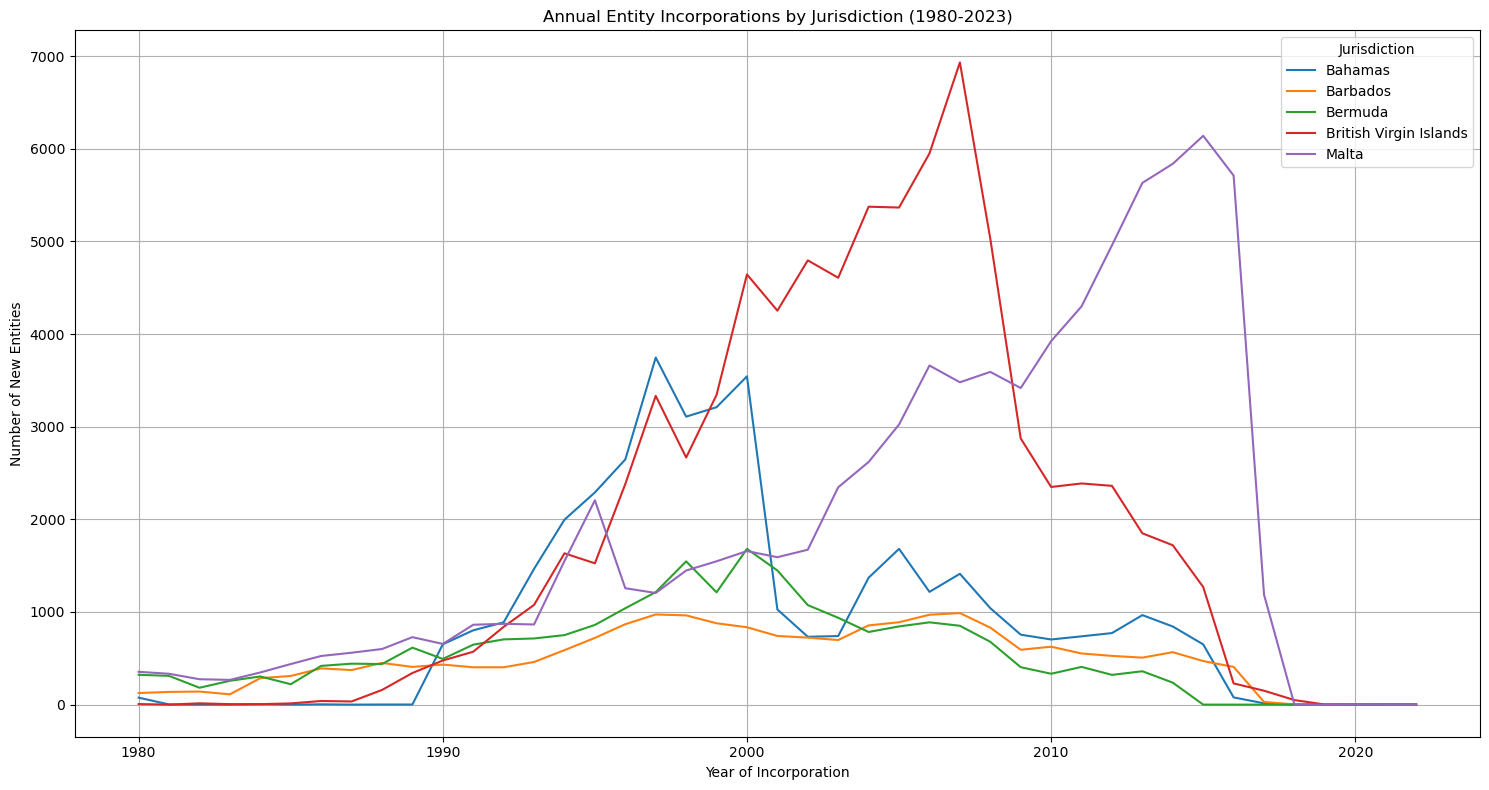

In [14]:
# --- Temporal Trend Analysis ---
print("\n--- Temporal Trend Analysis ---")

# Ensure 'incorporation_date_end' is datetime and extract year
df_entities_end['incorporation_date_end'] = pd.to_datetime(df_entities_end['incorporation_date_end'], errors='coerce')
df_entities_end['incorporation_year_end'] = df_entities_end['incorporation_date_end'].dt.year

# Filter out records with no valid incorporation year
df_temporal = df_entities_end[df_entities_end['incorporation_year_end'].notna()].copy()
df_temporal['incorporation_year_end'] = df_temporal['incorporation_year_end'].astype(int)

# Consider a relevant year range, e.g., based on data distribution or specific events
# For this example, let's assume years from 1980 to 2023
min_year = 1980
max_year = 2023 # Adjust as per actual data range and relevance
df_temporal = df_temporal[(df_temporal['incorporation_year_end'] >= min_year) & (df_temporal['incorporation_year_end'] <= max_year)]

# Count incorporations per year for top jurisdictions
# Using the 'top_jurisdictions' list from earlier, or redefine if needed
# top_jurisdictions_temporal = df_temporal['jurisdiction_description_end'].value_counts().head(7).index.tolist()
# For consistency, let's use the previously defined top_jurisdictions if suitable, or select new ones based on temporal data volume
if 'top_jurisdictions' not in locals() or not top_jurisdictions:
    top_jurisdictions_temporal = df_temporal[df_temporal['jurisdiction_description_end']!= 'unknown']['jurisdiction_description_end'].value_counts().nlargest(5).index.tolist()
else:
    top_jurisdictions_temporal = top_jurisdictions

df_temporal_top_jur = df_temporal[df_temporal['jurisdiction_description_end'].isin(top_jurisdictions_temporal)]

incorporations_by_year_jurisdiction = df_temporal_top_jur.groupby(['incorporation_year_end', 'jurisdiction_description_end']).size().unstack(fill_value=0)

print("\nAnnual Incorporations for Top Jurisdictions (Sample):")
print(incorporations_by_year_jurisdiction.tail()) # Display last few years

# Plotting the multi-line chart
if not incorporations_by_year_jurisdiction.empty:
    plt.figure(figsize=(15, 8))
    for jur in incorporations_by_year_jurisdiction.columns:
        plt.plot(incorporations_by_year_jurisdiction.index, incorporations_by_year_jurisdiction[jur], label=jur.title()) #.title() for better legend
    plt.title(f'Annual Entity Incorporations by Jurisdiction ({min_year}-{max_year})')
    plt.xlabel('Year of Incorporation')
    plt.ylabel('Number of New Entities')
    plt.legend(title='Jurisdiction')
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig('annual_incorporations_by_jurisdiction.png')
    # plt.show()
    print("\nPlot for annual incorporations by jurisdiction generated (commented out).")
else:
    print("\nNo data available for plotting annual incorporations for the selected top jurisdictions and year range.")


--- Regional Pattern Analysis ---

Entity Incorporations by Region:
incorporation_region_end
Caribbean              199385
Europe                  88361
Asia/Pacific            24120
Other/Unknown           22786
Central America         17027
Africa/Indian Ocean       684
North America (USA)       143
Name: count, dtype: int64

Top Entity Types by Incorporation Region (Sample):
   incorporation_region_end                             company_type_end  \
2       Africa/Indian Ocean                                      unknown   
1       Africa/Indian Ocean               standard international company   
0       Africa/Indian Ocean            private company limited by shares   
19             Asia/Pacific                                      unknown   
18             Asia/Pacific               standard international company   
6              Asia/Pacific  cook islands asset protection trust - 3520a   
36                Caribbean                                      unknown   
34        

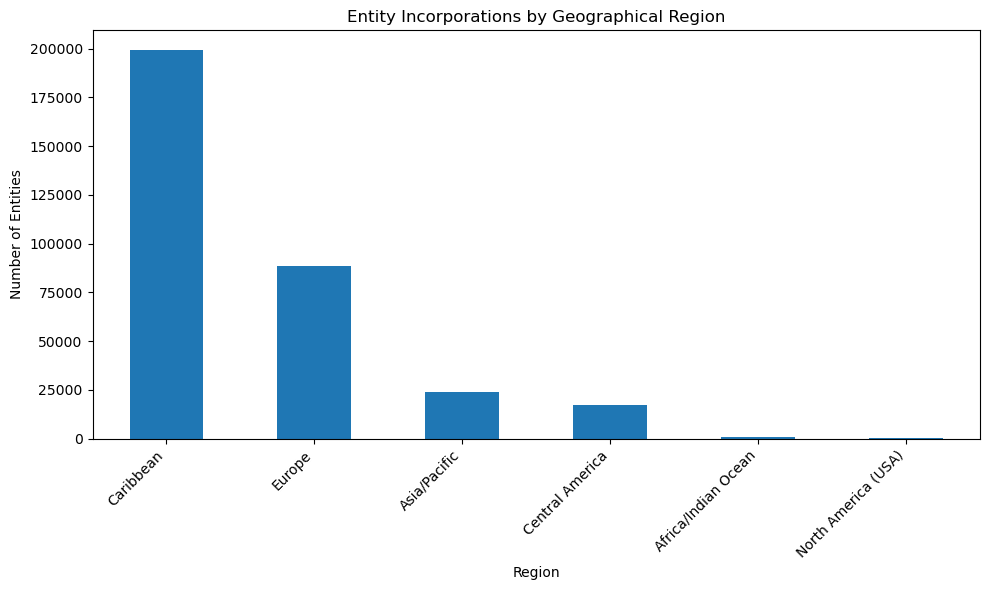

In [15]:
# --- Regional Pattern Analysis ---
print("\n--- Regional Pattern Analysis ---")

# Define a mapping of jurisdictions to broader geographical regions
# This mapping is based on the research snippets [35]-[60]
# Note: 'Undetermined' and 'Unknown' jurisdictions are typically excluded or handled separately.
jurisdiction_to_region = {
    # Caribbean
    'bahamas': 'Caribbean', 'british virgin islands': 'Caribbean', 'cayman islands': 'Caribbean',
    'aruba': 'Caribbean', 'saint kitts and nevis': 'Caribbean', # Nevis is part of St Kitts & Nevis
    'barbados': 'Caribbean', 'anguilla': 'Caribbean', 'bermuda': 'Caribbean', # Bermuda often grouped with Caribbean OFCs
    'turks and caicos islands': 'Caribbean', 'dominica': 'Caribbean', 'grenada': 'Caribbean',
    'u.s. virgin islands': 'Caribbean', 'curacao': 'Caribbean',

    # Europe
    'malta': 'Europe', 'cyprus': 'Europe', 'jersey': 'Europe', 'guernsey': 'Europe',
    'isle of man': 'Europe', 'liechtenstein': 'Europe', 'luxembourg': 'Europe',
    'switzerland': 'Europe', 'united kingdom': 'Europe', 'ireland': 'Europe',
    'gibraltar': 'Europe', 'monaco': 'Europe', 'andorra': 'Europe',

    # Asia/Pacific
    'samoa': 'Asia/Pacific', 'cook islands': 'Asia/Pacific', 'niue': 'Asia/Pacific',
    'hong kong': 'Asia/Pacific', 'singapore': 'Asia/Pacific',
    'vanuatu': 'Asia/Pacific', 'seychelles': 'Asia/Pacific',
    'mauritius': 'Africa/Indian Ocean', # Geographically closer to Africa, distinct from pure Pacific OFCs
    'labuan': 'Asia/Pacific', # Labuan is part of Malaysia

    # North America (for completeness, though primarily OFCs are elsewhere)
    'delaware': 'North America (USA)', 'united states': 'North America (USA)',
    'south dakota': 'North America (USA)', 'canada': 'North America',

    # Other (less common OFCs or major onshore that appear)
    'panama': 'Central America', # Often considered a Caribbean OFC in function
    # Add more mappings as needed based on full dataset inspection
}

# Apply region mapping to entity incorporation jurisdictions
df_entities_end['incorporation_region_end'] = df_entities_end['jurisdiction_description_end'].map(jurisdiction_to_region).fillna('Other/Unknown')

# Count entities by incorporation region
region_incorporation_counts = df_entities_end['incorporation_region_end'].value_counts()
print("\nEntity Incorporations by Region:")
print(region_incorporation_counts)

# Analyze entity types by region
entity_type_by_region = df_entities_end.groupby(['incorporation_region_end', 'company_type_end']).size().reset_index(name='count')
entity_type_by_region_sorted = entity_type_by_region.sort_values(by=['incorporation_region_end', 'count'], ascending=[True, False])
print("\nTop Entity Types by Incorporation Region (Sample):")
print(entity_type_by_region_sorted.groupby('incorporation_region_end').head(3)) # Show top 3 types per region

# Plotting entity counts by region
if not region_incorporation_counts[region_incorporation_counts.index!= 'Other/Unknown'].empty:
    plt.figure(figsize=(10, 6))
    region_incorporation_counts[region_incorporation_counts.index!= 'Other/Unknown'].plot(kind='bar')
    plt.title('Entity Incorporations by Geographical Region')
    plt.xlabel('Region')
    plt.ylabel('Number of Entities')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # plt.savefig('entity_incorporations_by_region.png')
    # plt.show()
    print("\nPlot for entity incorporations by region generated (commented out).")
else:
    print("\nNo data available for plotting entity incorporations by region (excluding 'Other/Unknown').")

# Code for choropleth map would involve:
# 1. Getting country codes or standardized country names for jurisdictions.
# 2. Aggregating the metric of interest (e.g., count of a specific entity type) by country.
# 3. Using a library like `geopandas` and `matplotlib` or `plotly` for plotting.
# This is more complex and depends on available shapefiles or geo-mapping capabilities.
# print("\nConceptual steps for choropleth map generation would be implemented here.")


--- Network Analysis ---

Network graph created with 99228 nodes and 89417 edges (sample).

Top 10 Nodes by Degree Centrality (Sample Network):
       node_id  degree_centrality                            name
40   230000018           0.053443   Morning Star Holdings Limited
6     23000136           0.022353  MOSSACK FONSECA & CO. (BAHAMAS
241   23000147           0.014905     UBS TRUSTEES (BAHAMAS) LTD.
69    23000156           0.013081  TRIDENT CORPORATE SERVICES (BA
315   23000330           0.012577     CREDIT SUISSE TRUST LIMITED
10    23000133           0.012577                MMG BAHAMAS LTD.
154   11001746           0.010804  ORION HOUSE SERVICES (HK) LIMI
183   32000236           0.010279                   Internal User
8       298333           0.008717  Unitrust Corporate Services Lt
408   23000213           0.007982  K.M.C. CORPORATE SERVICES LTD.


/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_90483/326241850.py:94: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



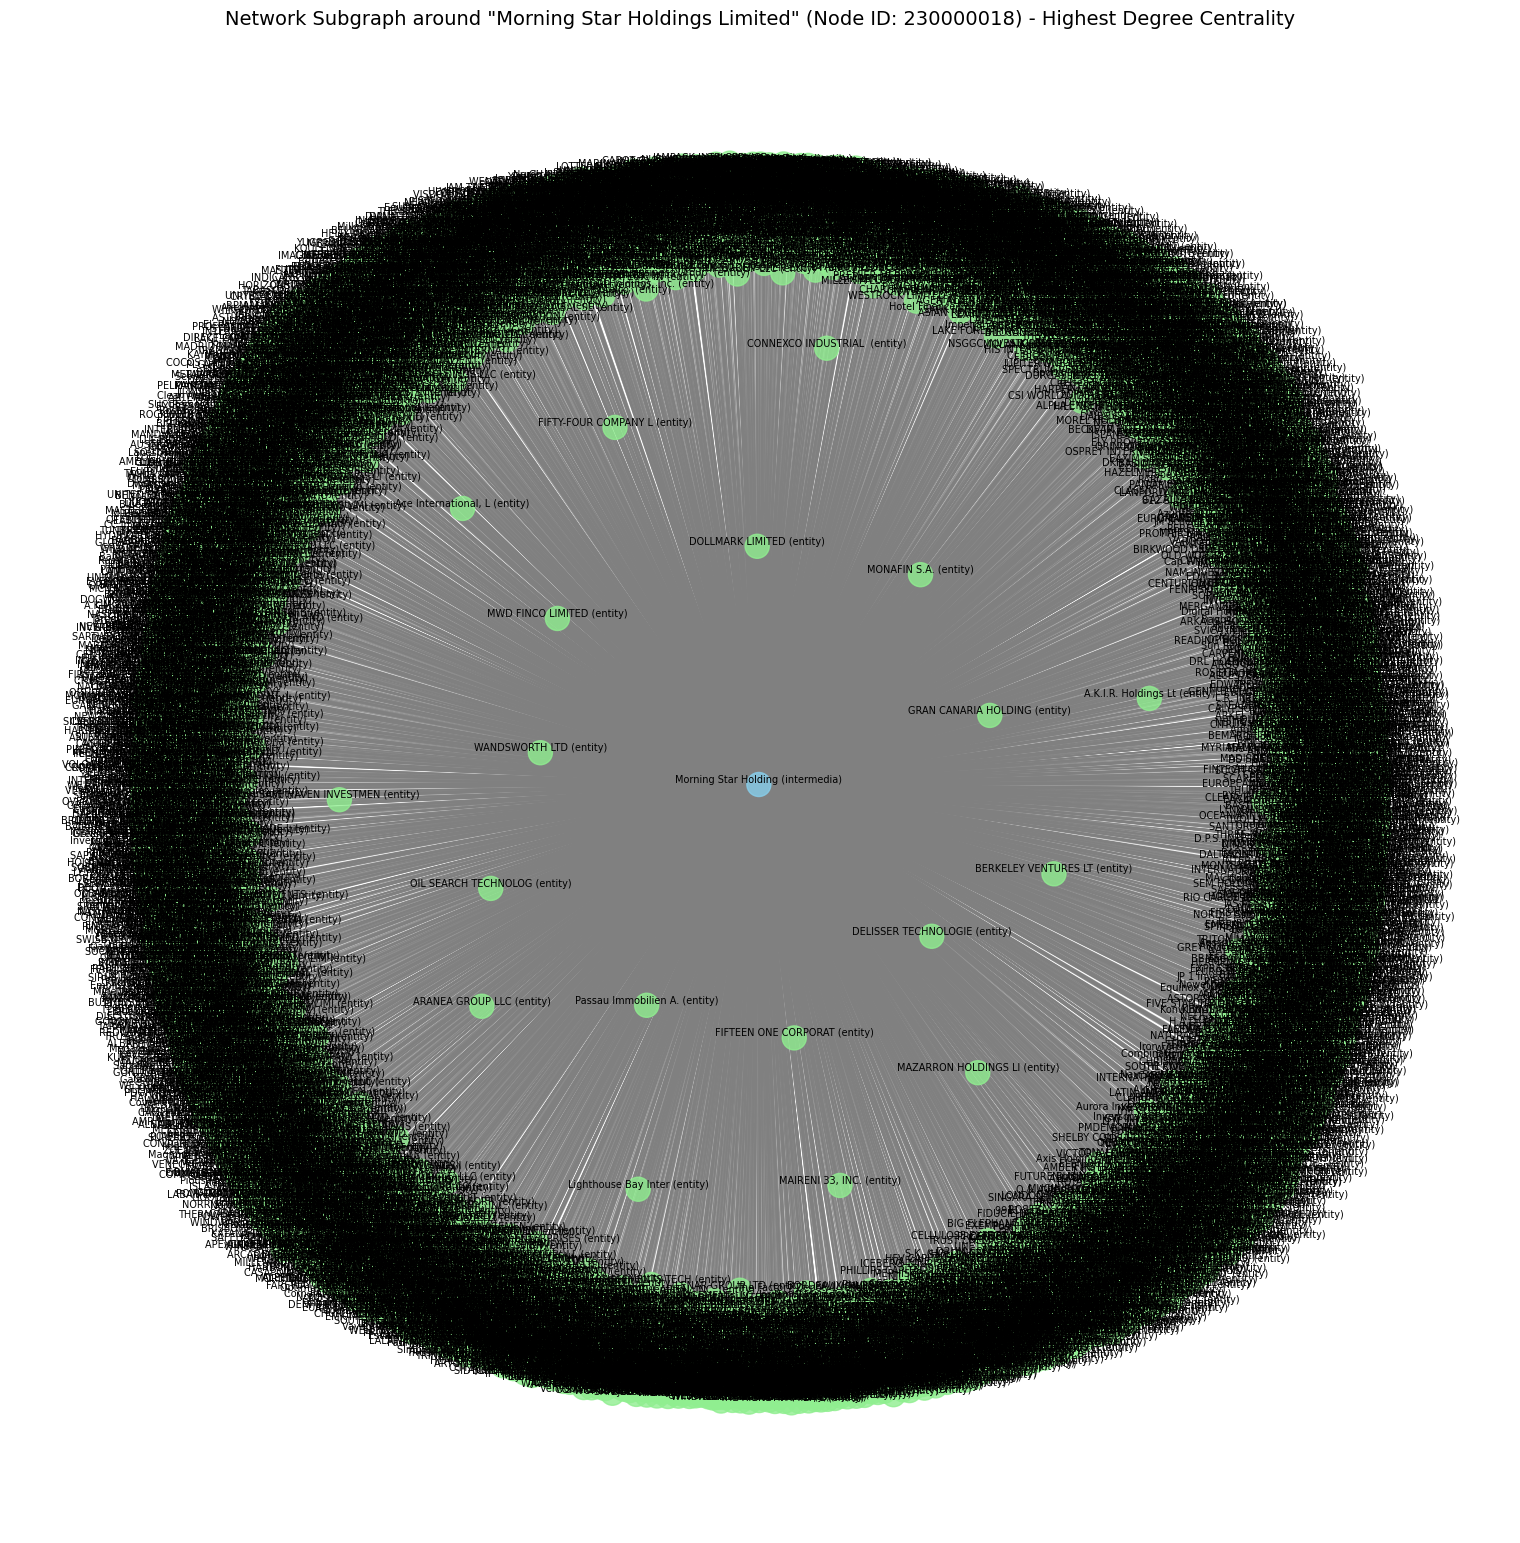


Network subgraph around node 'Morning Star Holdings Limited' (ID: 230000018) with highest degree centrality generated.


In [21]:
# --- Network Analysis ---
print("\n--- Network Analysis ---")

# For a manageable example, let's consider a subset of relationships,
# e.g., focusing on intermediaries and the entities they are connected to.
# We will use 'node_id_start' and 'node_id_end' for edges.

# Filter for 'intermediary_of' relationships
df_network_sample = df[df['rel_type'] == 'intermediary_of'].copy()
df_network_sample = df_network_sample[['node_id_start', 'node_id_end', 'name_start', 'name_end', 'node_type_start', 'node_type_end', 'jurisdiction_description_start', 'jurisdiction_description_end']]

# Limit to a smaller number of edges for initial visualization if the dataset is very large
# df_network_sample = df_network_sample.head(100) # Example limit

# Create a graph
G = nx.Graph() # Or nx.DiGraph() if directionality is key for all rel_types

# Add nodes and edges
# We can add attributes to nodes, like name, type, jurisdiction
for index, row in df_network_sample.iterrows():
    # Add start node with attributes
    G.add_node(row['node_id_start'],
               name=row['name_start'][:30] if pd.notna(row['name_start']) else 'UnknownStart', # Truncate long names
               type=row['node_type_start'],
               jurisdiction=row['jurisdiction_description_start'])
    # Add end node with attributes
    G.add_node(row['node_id_end'],
               name=row['name_end'][:30] if pd.notna(row['name_end']) else 'UnknownEnd', # Truncate long names
               type=row['node_type_end'],
               jurisdiction=row['jurisdiction_description_end'])
    # Add edge
    G.add_edge(row['node_id_start'], row['node_id_end'], relation_type='intermediary_of')

print(f"\nNetwork graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges (sample).")

# Calculate degree centrality for nodes (example metric)
if G.number_of_nodes() > 0:
    degree_centrality = nx.degree_centrality(G)
    # Convert to DataFrame for easier viewing/sorting
    df_degree_centrality = pd.DataFrame(list(degree_centrality.items()), columns=['node_id', 'degree_centrality'])
    # Add node names for context
    node_names = {node: G.nodes[node].get('name', str(node)) for node in G.nodes()}
    df_degree_centrality['name'] = df_degree_centrality['node_id'].map(node_names)
    df_degree_centrality = df_degree_centrality.sort_values(by='degree_centrality', ascending=False)
    print("\nTop 10 Nodes by Degree Centrality (Sample Network):")
    print(df_degree_centrality.head(10))

    # Visualize a small subgraph (e.g., around a high-centrality node)
    if not df_degree_centrality.empty:
        # Create a subgraph around the node with highest degree centrality
        top_node_id = df_degree_centrality.iloc[0]['node_id']
        top_node_name = df_degree_centrality.iloc[0]['name']

        # Create an ego graph (nodes within 1 hop of the top_node_id)
        # If the ego graph is too large, consider a smaller radius or a fixed number of neighbors.
        # For this example, let's limit the size of the ego graph if it's very dense.
        ego_graph = nx.ego_graph(G, top_node_id, radius=1)

        # If the ego_graph is still too large for clear visualization,
        # you might want to further prune it or select a different visualization strategy.
        # For now, we'll proceed with the ego_graph.
        
        if ego_graph.number_of_nodes() > 0:
            plt.figure(figsize=(15, 15)) # Increased size for better readability
            # Use a layout that spreads nodes out, k adjusts spacing
            pos = nx.spring_layout(ego_graph, k=0.6, iterations=40, seed=42)
            
            # Prepare labels: use node names, fallback to ID if name is missing or too generic
            labels = {}
            for node in ego_graph.nodes():
                node_data = G.nodes[node]
                name = node_data.get('name', str(node))
                node_type = node_data.get('type', 'Unknown Type')
                # Make labels more informative, e.g., Name (Type)
                labels[node] = f"{name[:20]} ({node_type[:10]})" # Truncate long names/types

            # Draw nodes with different colors based on type (example)
            node_colors = []
            for node in ego_graph.nodes():
                node_type = G.nodes[node].get('type')
                if node_type == 'intermediary':
                    node_colors.append('skyblue')
                elif node_type == 'entity':
                    node_colors.append('lightgreen')
                elif node_type == 'officer':
                    node_colors.append('salmon')
                else:
                    node_colors.append('grey')

            nx.draw(ego_graph, pos, with_labels=False, node_color=node_colors, node_size=300, font_size=8, alpha=0.8, edge_color='gray')
            nx.draw_networkx_labels(ego_graph, pos, labels=labels, font_size=7, verticalalignment='bottom')
            
            plt.title(f'Network Subgraph around "{top_node_name}" (Node ID: {top_node_id}) - Highest Degree Centrality', fontsize=14)
            plt.tight_layout()
            # plt.savefig('sample_network_subgraph_highest_centrality.png') # Uncomment to save
            plt.show()
            print(f"\nNetwork subgraph around node '{top_node_name}' (ID: {top_node_id}) with highest degree centrality generated.")
        else:
            print(f"\nEgo graph for node '{top_node_name}' (ID: {top_node_id}) is empty or could not be generated.")

    else:
        print("\nDegree centrality data is empty, cannot select a top node for subgraph visualization.")

else:
    print("\nNetwork graph is empty, skipping centrality calculation and visualization.")

In [17]:
# --- Utility Functions (Example) ---
print("\n--- Utility Functions ---")

def summarize_column_uniques(df, column_name):
    """Prints unique values and their frequencies for a given column."""
    if column_name in df.columns:
        print(f"\nUnique values and frequencies for '{column_name}':")
        print(df[column_name].value_counts(dropna=False))
    else:
        print(f"Column '{column_name}' not found in DataFrame.")

# Example usage:
# summarize_column_uniques(df, 'rel_type')
# summarize_column_uniques(df, 'sourceID')

def clean_jurisdiction_name(name):
    """A more advanced function to standardize jurisdiction names if needed."""
    name = str(name).lower().strip()
    # Add specific replacements if common variations exist
    # e.g., if 'b.v.i.' should be 'british virgin islands'
    # name = name.replace('b.v.i.', 'british virgin islands')
    return name

# df['jurisdiction_description_end_cleaned'] = df['jurisdiction_description_end'].apply(clean_jurisdiction_name)

print("Utility function examples defined.")
print("\n--- End of Python Code Appendix Outline ---")


--- Utility Functions ---
Utility function examples defined.

--- End of Python Code Appendix Outline ---
